# Advanced Lane Finding

### 1- Camera Calebraion and Distortion Correction : 

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:

def calibrate_distort_cam(images, test_image_name='test', corners_w=9, corners_h=6):
    """
    @param: images , array of images paths ['folder//image_name.jpg',..]
    """
    # prepare object points, 
    # 6*8 length arrays, length=3 each , like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((corners_w*corners_h,3), np.float32)
    objp[:,:2] = np.mgrid[0:corners_w, 0:corners_h].T.reshape(-1,2)#create grid of 2 arrays, then reshape to 6*9, then replace values in objp
    """output :
    [[ 0.  0.  0.]
     [ 1.  0.  0.]
     ...
     [ 7.  5.  0.]
     [ 8.  5.  0.]]
    """
    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.
    
    # Step through the list and search for chessboard corners
    for idx, fname in enumerate(images):
        img = cv2.imread(fname)#read image
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)#convert to gray
        
        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
    
    f, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2, 2, figsize=(20,10))
    ax1.imshow(img)
    ax1.set_title('chess board', fontsize=20)
    # Draw and display the corners of an image
    cv2.drawChessboardCorners(img, (9,6), corners, ret)
    
    ax2.imshow(img)
    ax2.set_title('chess board inner corners', fontsize=20)
    #calibration 
    test_img = cv2.imread('camera_cal/'+test_image_name+'.jpg')
    img_size = (test_img.shape[1], test_img.shape[0])

    # Do camera calibration given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
        
    # Test undistortion on an image
    undistorted_img = cv2.undistort(test_img, mtx, dist, None, mtx)
    #display
    ax3.imshow(test_img)
    ax3.set_title('Original Image', fontsize=20)
    ax4.imshow(undistorted_img)
    ax4.set_title('Undistorted Image', fontsize=20)
    
    return mtx, dist


In [3]:
import pickle
def save_calibration(mtx, dist, folder='camera_cal'):
    # Save the camera calibration result for later use
    dist_pickle = {}
    dist_pickle["mtx"] = mtx
    dist_pickle["dist"] = dist
    pickle.dump( dist_pickle, open( folder+"/wide_dist_pickle.p", "wb" ) )

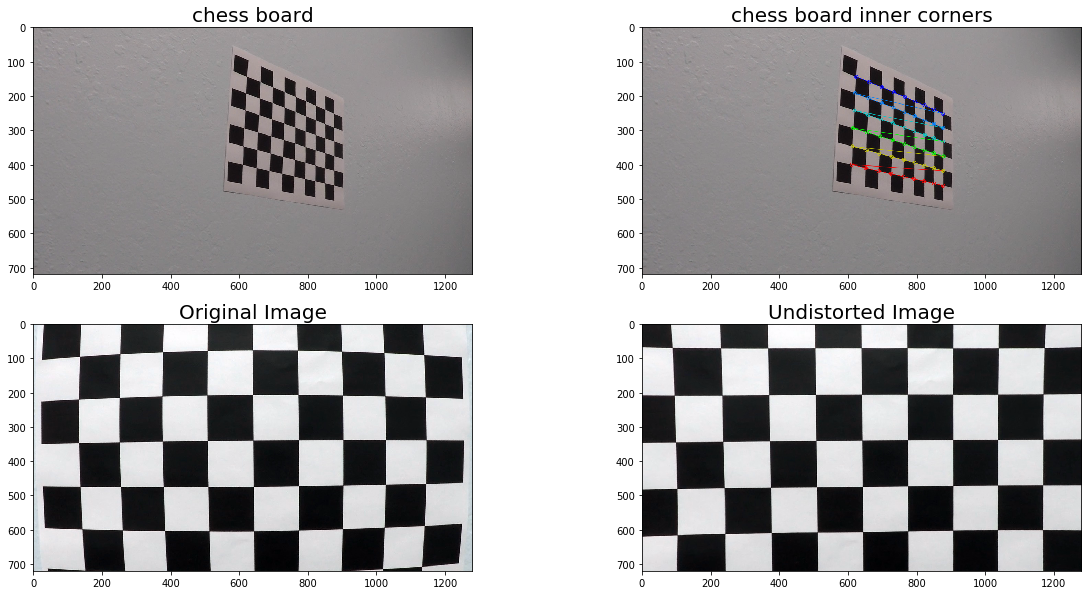

In [4]:
# Make a list of calibration images urls
images = glob.glob('camera_cal/calibration*.jpg')
mtx, dist = calibrate_distort_cam(images)
    
save_calibration(mtx, dist)



### 2-  Color/Gradient Threshold

In [5]:
import matplotlib.image as mpimg
def abs_sobel_thresh(s_channel, orient='x', sobel_kernel=3, s_thresh=(0, 255)):
    
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'y':
        sobel = cv2.Sobel(s_channel, cv2.CV_64F, 0, 1, ksize=sobel_kernel) # Take the derivative in y
    else:
        sobel = cv2.Sobel(s_channel, cv2.CV_64F, 1, 0, ksize=sobel_kernel) # Take the derivative in x
    
    abs_sobel = np.absolute(sobel) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    # Threshold x gradient
    sobel_binary = np.zeros_like(scaled_sobel)
    sobel_binary[(scaled_sobel >= s_thresh[0]) & (scaled_sobel <= s_thresh[1])] = 1
    
    return sobel_binary

In [6]:
def s_hls_thresh(s_channel, s_thresh=(0, 255)):
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Return the result
    return s_binary

In [7]:
def pipeline_gradiant_thresh(img, s_thresh=(170, 255), sobel_thresh=(30, 70), do_plot=False):  
    img = cv2.undistort(img, mtx, dist, None, mtx)
    
    #img_yuv = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    # equalize the histogram of the Y channel
    #img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
    #img_yuv[:,:,2] = cv2.equalizeHist(img_yuv[:,:,2])
    # convert the YUV image back to RGB format
    #img = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)
    
    # Choose a Sobel kernel size
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    #hsv = cv2.cvtColor(img_contrast, cv2.COLOR_RGB2HLS).astype(np.float)
    
    s_channel = hls[:,:,2]
    l_channel = hls[:,:,1]
    # Apply each of the thresholding functions
    sobel_x_binary = abs_sobel_thresh(l_channel, orient='x', sobel_kernel=1, s_thresh=sobel_thresh)
    s_binary = s_hls_thresh(s_channel, s_thresh=s_thresh)
    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(sobel_x_binary), sobel_x_binary, s_binary))
    
    if do_plot:
        f, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2, 3, figsize=(24, 13))
        f.tight_layout()
        f.suptitle("Sobel X with L channel & S channel thresholded :", fontsize=30)

        ax1.imshow(img)
        ax1.set_title('Original image', fontsize=20)

        ax4.imshow(img)
        ax4.set_title('Original image', fontsize=20)

        ax2.imshow(l_channel)
        ax2.set_title('L channel of image HLS', fontsize=20)

        ax5.imshow(s_channel)
        ax5.set_title('S channel of image HLS', fontsize=20)

        ax3.imshow(sobel_x_binary, cmap='gray')
        ax3.set_title('Binary Sobel X', fontsize=20)

        ax6.imshow(s_binary, cmap='gray')
        ax6.set_title('S Channel Binary', fontsize=20)
    return color_binary, sobel_x_binary , s_binary 

In [8]:
def compine_sobel_schannel(sobelx_binary, schannel_binary, result, do_plot=False):
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sobelx_binary)
    combined_binary[(schannel_binary == 1) | (sobelx_binary == 1)] = 1
    
    if do_plot:
        f, (ax1,ax2) = plt.subplots(1, 2, figsize=(12, 5))
        f.tight_layout()
        f.suptitle("Combined Results :", fontsize=30)
        ax1.imshow(result)
        ax1.set_title('Pipeline Result', fontsize=20)

        ax2.imshow(combined_binary, cmap='gray')
        ax2.set_title('Combined Binary', fontsize=20)
    return combined_binary

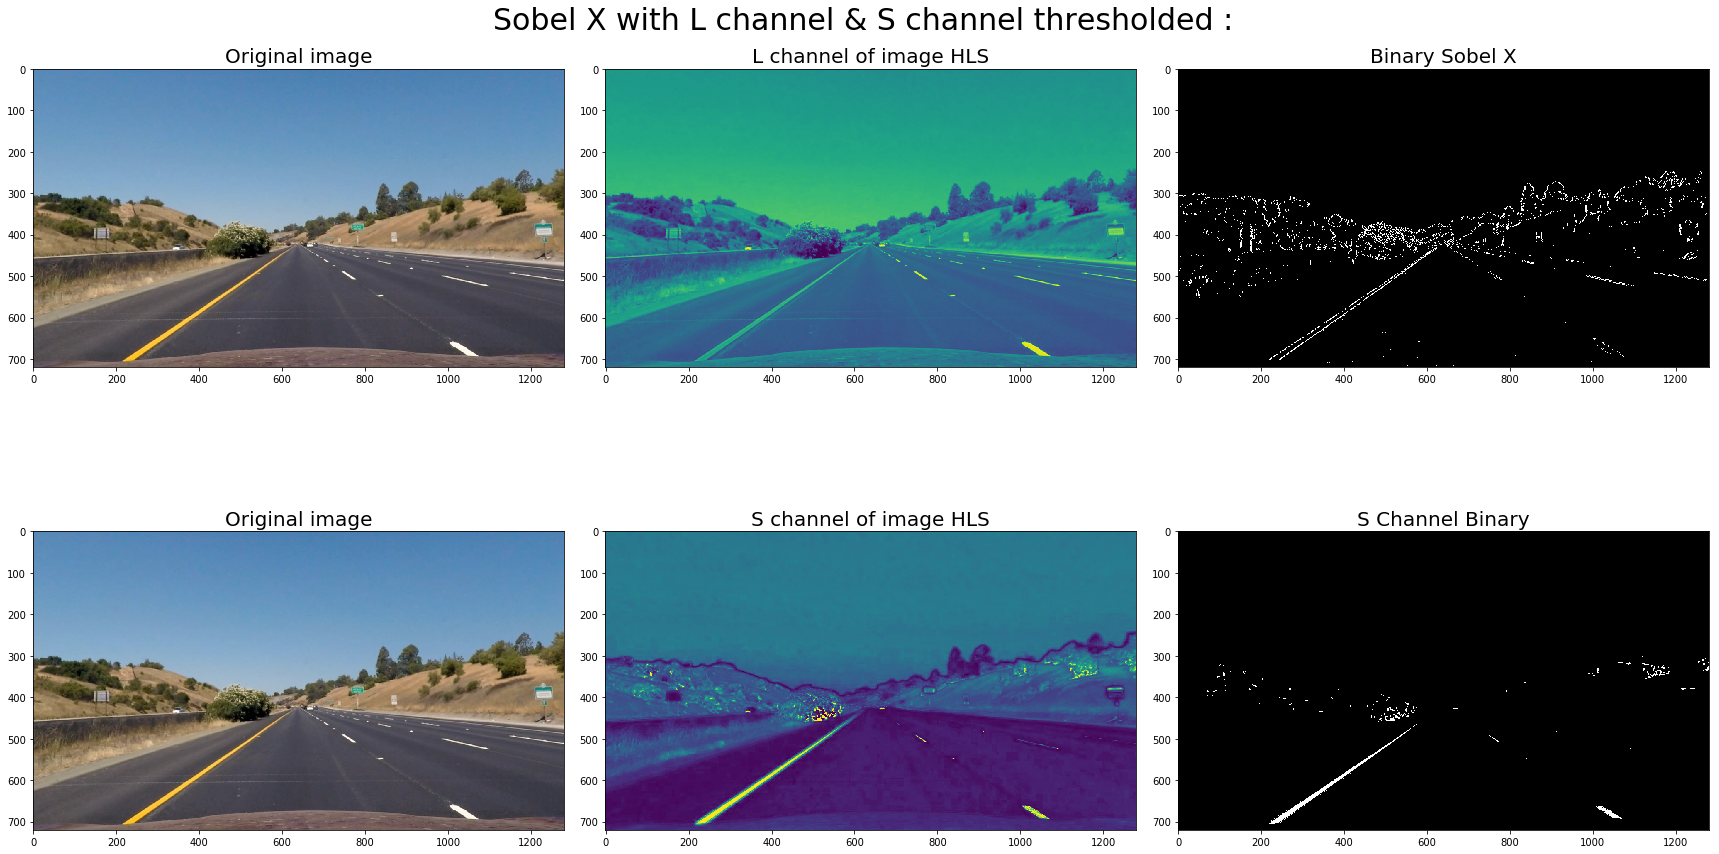

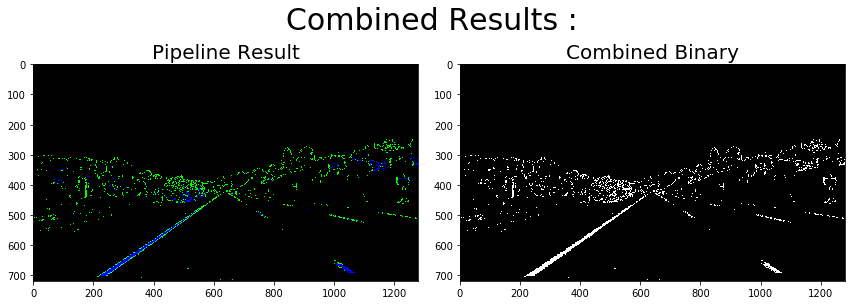

In [9]:
image = cv2.imread('test_images/straight_lines1.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
result, sobelx_binary, schannel_binary = pipeline_gradiant_thresh(image, do_plot=True)

#TODO: add to pipeline functions 
combined_binary = compine_sobel_schannel(sobelx_binary, schannel_binary, result, do_plot=True)

### 3- Perspective transform

##### 3a - adjust prespective on an image that has a straight lane line 

warped_img (720, 1280)


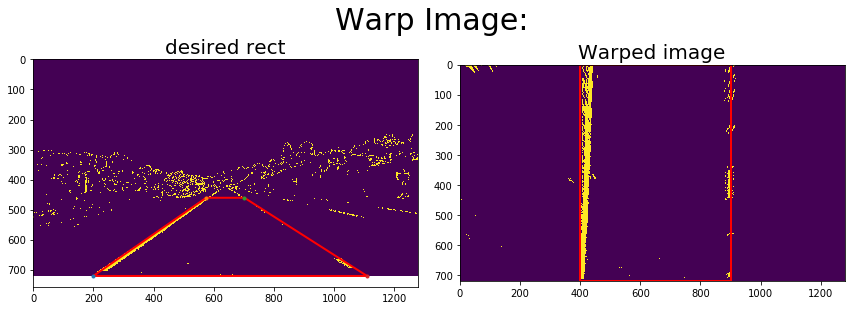

In [10]:
import matplotlib.patches as patches

def warp(image, do_plot=False):
   
    img_size = (image.shape[1], image.shape[0])
    horizon = int(img_size[1]*.64)#0.62
    
    src_vertices = np.float32(
        [[200,     img_size[1]],#LB
        [575, horizon],         #LT
        [702, horizon], 
        [1110,     img_size[1]]])
        #[[200,     img_size[1]],#LB
        #[599, horizon],         #LT
        #[678, horizon], 
        #[1110,     img_size[1]]])
    
    dst_vertices = np.float32(
        [[400, 720],
        [400, 0], 
        [900, 0], 
        [900, 720]])
        
    #warp matrix
    M = cv2.getPerspectiveTransform(src_vertices, dst_vertices)
    #unwarp matrix
    Minv = cv2.getPerspectiveTransform(dst_vertices, src_vertices)
    #do warp 
    warped = cv2.warpPerspective(image, M, img_size, flags=cv2.INTER_LINEAR)
    
    if do_plot:
        f, (ax1,ax2) = plt.subplots(1, 2, figsize=(12, 5))
        f.tight_layout()
        f.suptitle("Warp Image:", fontsize=30)
        ax1.imshow(image)
        ax1.plot(src_vertices[0][0],src_vertices[0][1],'.')
        ax1.plot(src_vertices[1][0],src_vertices[1][1],'.')
        ax1.plot(src_vertices[2][0],src_vertices[2][1],'.')
        ax1.plot(src_vertices[3][0],src_vertices[3][1],'.')
        ax1.add_patch(patches.Polygon(src_vertices, linewidth=2, edgecolor='r', facecolor='none'))
        ax1.set_title('desired rect', fontsize=20)
        ax2.imshow(warped)
        ax2.add_patch(patches.Polygon(dst_vertices, linewidth=2, edgecolor='r', facecolor='none'))
        #ax2.add_patch(patches.Rectangle((290,0),750,720,linewidth=2,edgecolor='r',facecolor='none'))
        ax2.set_title('Warped image', fontsize=20)

    return warped

warped_img = warp(combined_binary , do_plot=True)
print("warped_img",warped_img.shape)

###### 3b - test same process on curved line

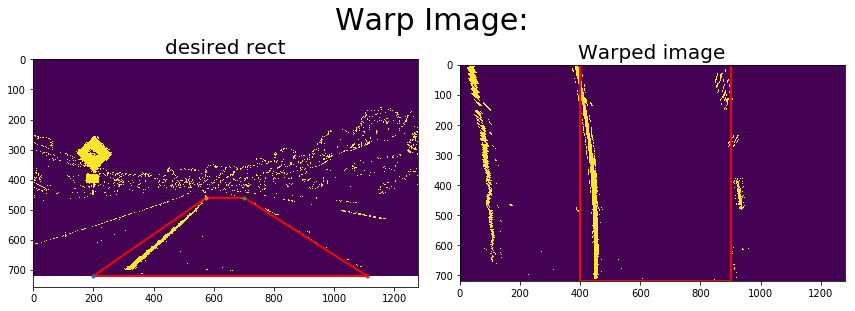

In [11]:
curved_image2 = cv2.imread('test_images/test2.jpg')
curved_image2 = cv2.cvtColor(curved_image2, cv2.COLOR_BGR2RGB)
curved_result2, curved_sobelx_binary2, curved_schannel_binary2 = pipeline_gradiant_thresh(curved_image2, do_plot=False)

#TODO: add to pipeline functions 
curved_combined_binary2 = compine_sobel_schannel(curved_sobelx_binary2, curved_schannel_binary2,curved_result2,do_plot=False)

curved_warped_img2 = warp(curved_combined_binary2 , do_plot=True)

another test, the other way

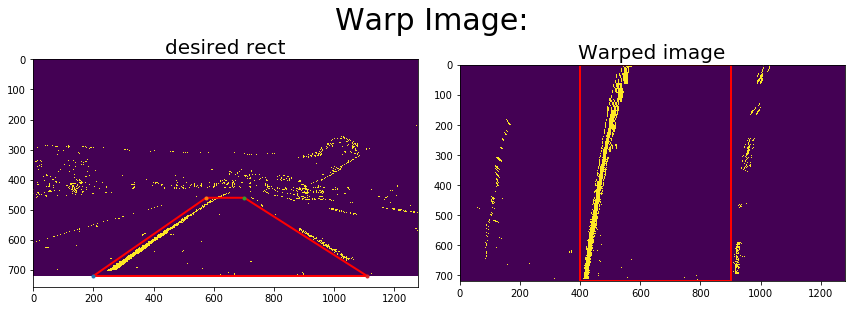

In [12]:
curved_image3 = cv2.imread('test_images/test3.jpg')
curved_image3 = cv2.cvtColor(curved_image3, cv2.COLOR_BGR2RGB)
curved_result3, curved_sobelx_binary3, curved_schannel_binary3 = pipeline_gradiant_thresh(curved_image3, do_plot=False)

#TODO: add to pipeline functions 
curved_combined_binary3 = compine_sobel_schannel(curved_sobelx_binary3, curved_schannel_binary3,curved_result3,do_plot=False)

curved_warped_img3 = warp(curved_combined_binary3 , do_plot=True)

bright lighting conditions

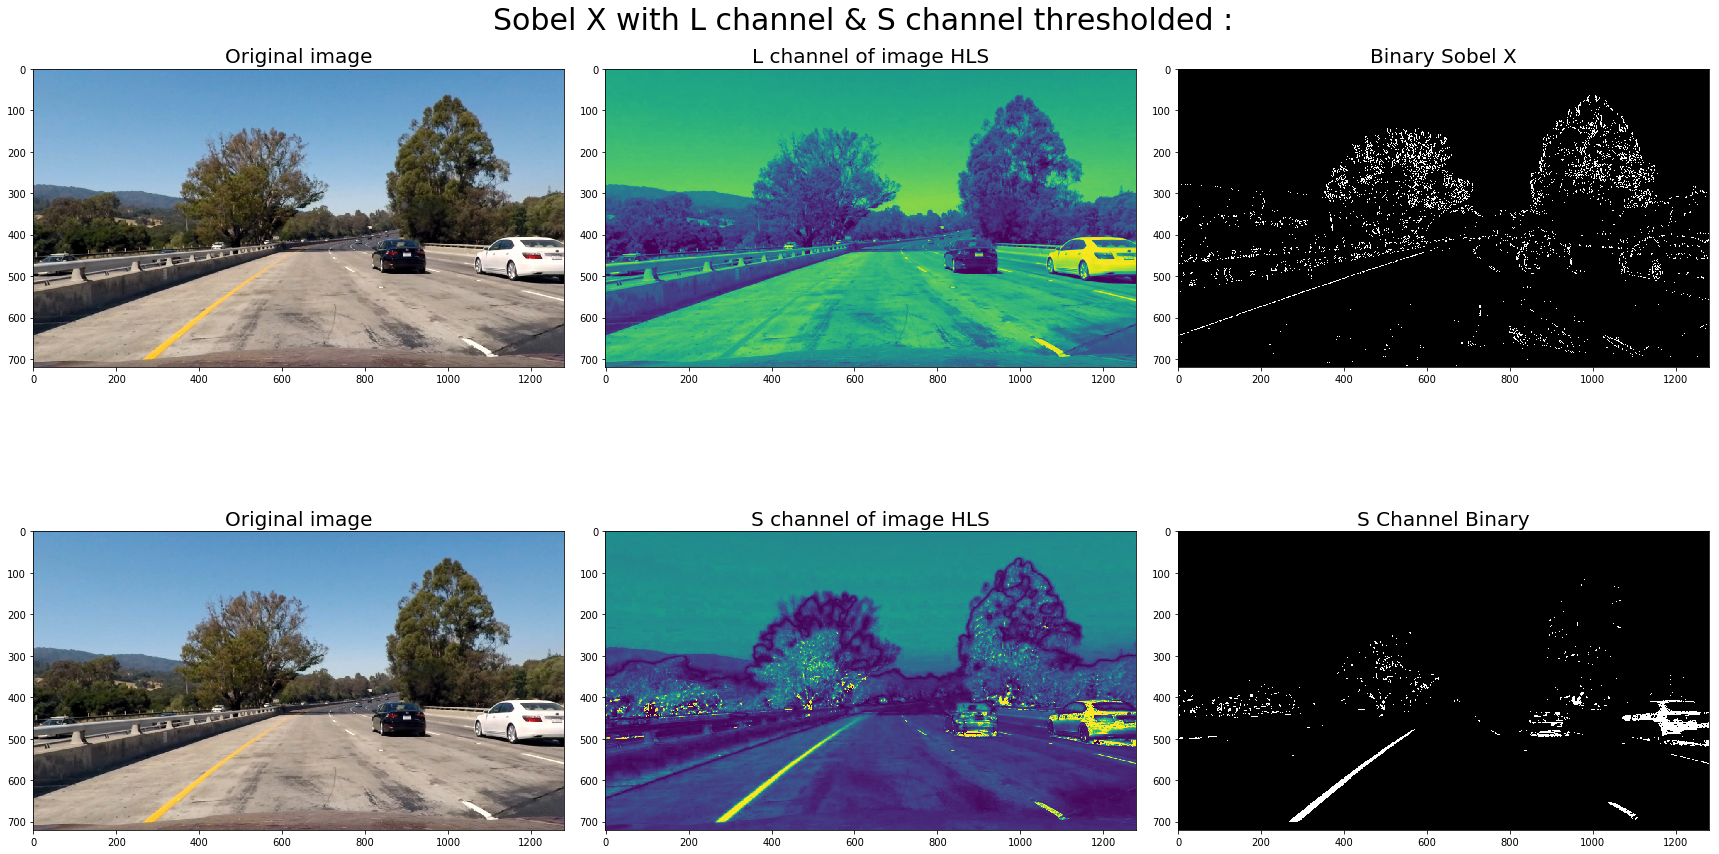

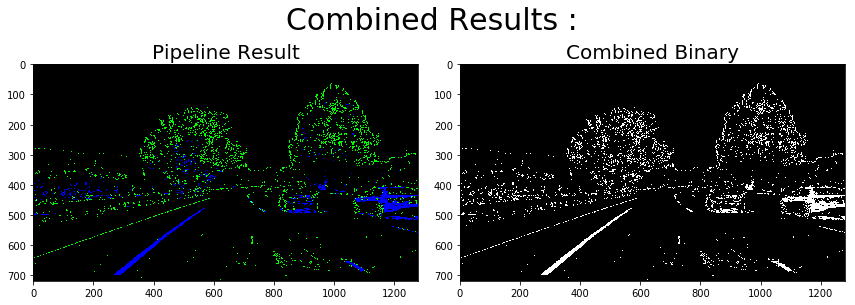

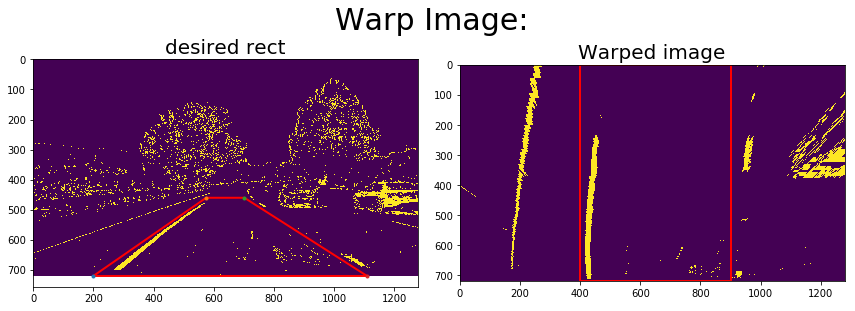

In [13]:
curved_image1 = cv2.imread('test_images/test1.jpg')
curved_image1 = cv2.cvtColor(curved_image1, cv2.COLOR_BGR2RGB)
curved_result1, curved_sobelx_binary1, curved_schannel_binary1 = pipeline_gradiant_thresh(curved_image1, do_plot=True)

#TODO: add to pipeline functions 
curved_combined_binary1 = compine_sobel_schannel(curved_sobelx_binary1, curved_schannel_binary1, curved_result1, do_plot=True)

curved_warped_img1 = warp(curved_combined_binary1 , do_plot=True)

another crazy lighting conditions

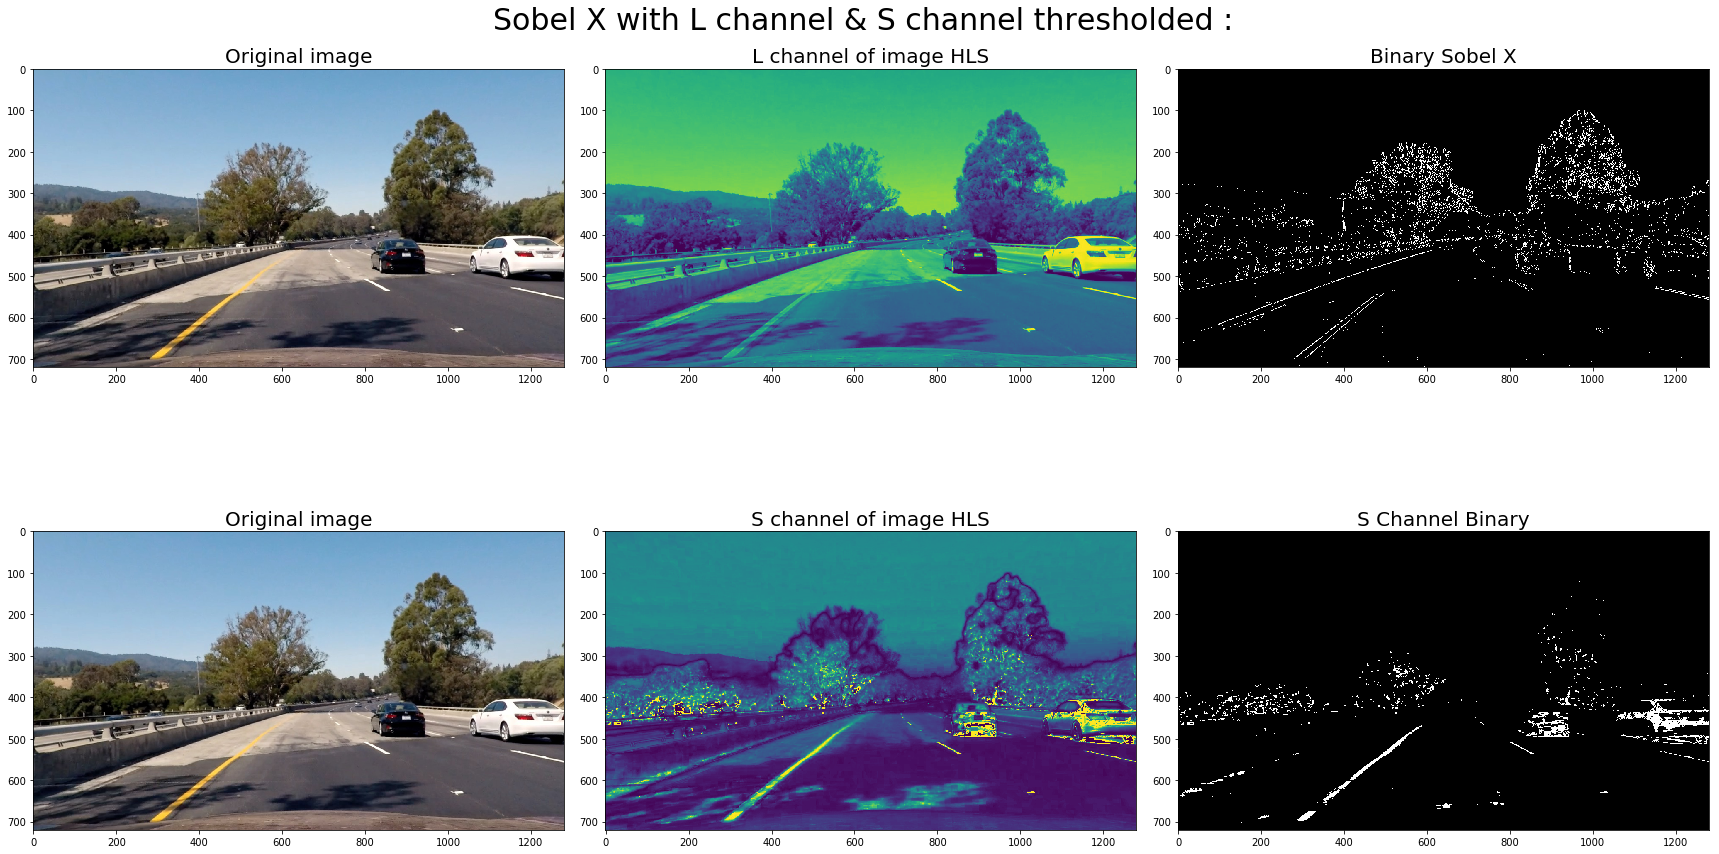

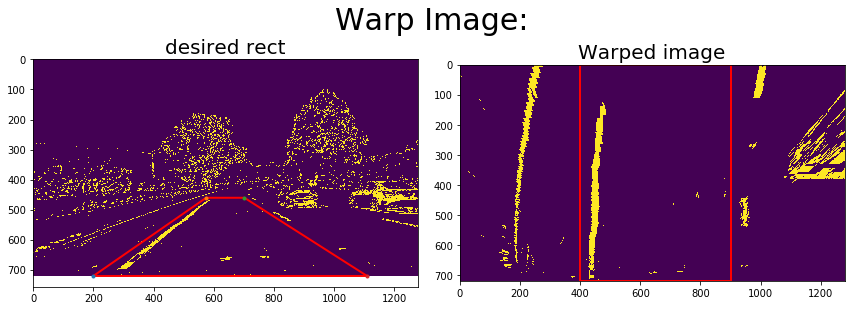

In [14]:
curved_image4 = cv2.imread('test_images/test4.jpg')
curved_image4 = cv2.cvtColor(curved_image4, cv2.COLOR_BGR2RGB)
curved_result4, curved_sobelx_binary4, curved_schannel_binary4 = pipeline_gradiant_thresh(curved_image4, do_plot=True)

#TODO: add to pipeline functions 
curved_combined_binary4 = compine_sobel_schannel(curved_sobelx_binary4, curved_schannel_binary4, curved_result4, do_plot=False)

curved_warped_img4 = warp(curved_combined_binary4 , do_plot=True)

### 4- find the lane in the bird-eye image

dedecting lane for :
- warped_img : which is straight line
- curved_warped_img2 : clear curved to left
- curved_warped_img3 : clear curved to right
- curved_warped_img1 : confusing curved to right


warped shape (720, 1280)


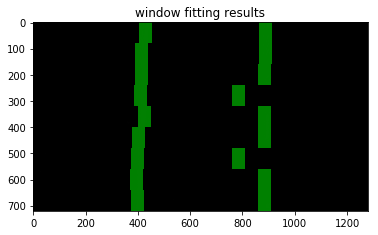

oppa


array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ..., 
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ..., 
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ..., 
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ..., 
       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ..., 
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ..., 
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ..., 
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

In [15]:
#trying lesson 34 code
from slidingwindow import sliding_window_search
sliding_window_search(warped_img,do_plot=True)


C:\D\Anas\mozakra\ML\CarND013\term1\CarND-Project4_Advanced-Lane-Lines\lanesearch.py:16: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)


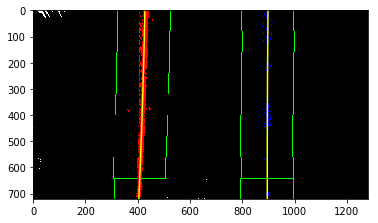

left_fitx: [ 427.40826044  427.38932167  427.37034684  427.35133597  427.33228905
  427.31320608  427.29408706  427.27493199  427.25574088  427.23651372
  427.21725051  427.19795125  427.17861594  427.15924459  427.13983719
  427.12039374  427.10091424  427.08139869  427.0618471   427.04225945
  427.02263576  427.00297602  426.98328024  426.9635484   426.94378052
  426.92397659  426.90413661  426.88426058  426.86434851  426.84440038
  426.82441621  426.80439599  426.78433972  426.76424741  426.74411904
  426.72395463  426.70375417  426.68351766  426.66324511  426.6429365
  426.62259185  426.60221115  426.5817944   426.5613416   426.54085276
  426.52032787  426.49976693  426.47916994  426.4585369   426.43786781
  426.41716268  426.3964215   426.37564427  426.35483099  426.33398167
  426.31309629  426.29217487  426.2712174   426.25022388  426.22919432
  426.2081287   426.18702704  426.16588933  426.14471557  426.12350577
  426.10225991  426.08097801  426.05966006  426.03830606  426.01691

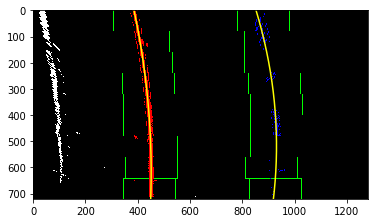

left_fitx: [ 386.0328298   386.24505337  386.45693279  386.66846808  386.87965922
  387.09050623  387.30100909  387.51116781  387.7209824   387.93045284
  388.13957914  388.34836131  388.55679933  388.76489321  388.97264295
  389.18004855  389.38711002  389.59382734  389.80020052  390.00622956
  390.21191446  390.41725522  390.62225183  390.82690431  391.03121265
  391.23517685  391.43879691  391.64207282  391.8450046   392.04759224
  392.24983573  392.45173509  392.6532903   392.85450138  393.05536831
  393.25589111  393.45606976  393.65590428  393.85539465  394.05454088
  394.25334297  394.45180093  394.64991474  394.84768441  395.04510994
  395.24219133  395.43892858  395.63532169  395.83137066  396.02707549
  396.22243618  396.41745273  396.61212514  396.80645341  397.00043754
  397.19407752  397.38737337  397.58032508  397.77293264  397.96519607
  398.15711536  398.3486905   398.53992151  398.73080837  398.9213511
  399.11154968  399.30140412  399.49091443  399.68008059  399.86890

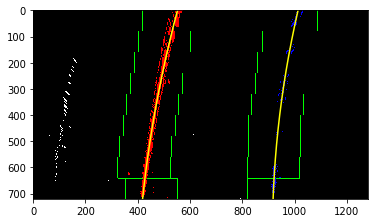

left_fitx: [ 551.98992291  551.7241352   551.45857198  551.19323324  550.92811899
  550.66322921  550.39856392  550.13412311  549.86990678  549.60591493
  549.34214757  549.07860468  548.81528628  548.55219236  548.28932293
  548.02667797  547.7642575   547.50206151  547.24009     546.97834297
  546.71682042  546.45552236  546.19444878  545.93359968  545.67297506
  545.41257493  545.15239927  544.8924481   544.63272141  544.3732192
  544.11394148  543.85488823  543.59605947  543.33745519  543.07907539
  542.82092008  542.56298924  542.30528289  542.04780102  541.79054363
  541.53351072  541.2767023   541.02011836  540.7637589   540.50762392
  540.25171342  539.99602741  539.74056587  539.48532882  539.23031625
  538.97552817  538.72096456  538.46662544  538.2125108   537.95862064
  537.70495496  537.45151376  537.19829705  536.94530482  536.69253707
  536.4399938   536.18767502  535.93558071  535.68371089  535.43206555
  535.18064469  534.92944832  534.67847643  534.42772901  534.17720

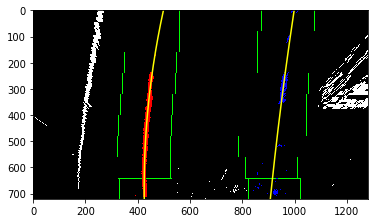

left_fitx: [ 498.19368824  497.97633406  497.75930185  497.54259161  497.32620333
  497.11013702  496.89439268  496.6789703   496.46386989  496.24909145
  496.03463498  495.82050047  495.60668792  495.39319735  495.18002874
  494.9671821   494.75465742  494.54245471  494.33057397  494.11901519
  493.90777838  493.69686354  493.48627067  493.27599976  493.06605082
  492.85642384  492.64711883  492.43813579  492.22947472  492.02113561
  491.81311847  491.60542329  491.39805008  491.19099884  490.98426957
  490.77786226  490.57177692  490.36601354  490.16057214  489.95545269
  489.75065522  489.54617971  489.34202617  489.1381946   488.93468499
  488.73149735  488.52863168  488.32608797  488.12386623  487.92196645
  487.72038865  487.51913281  487.31819893  487.11758703  486.91729709
  486.71732911  486.51768311  486.31835907  486.11935699  485.92067689
  485.72231875  485.52428257  485.32656837  485.12917613  484.93210585
  484.73535755  484.53893121  484.34282684  484.14704443  483.9515

(array([ 498.19368824,  497.97633406,  497.75930185,  497.54259161,
         497.32620333,  497.11013702,  496.89439268,  496.6789703 ,
         496.46386989,  496.24909145,  496.03463498,  495.82050047,
         495.60668792,  495.39319735,  495.18002874,  494.9671821 ,
         494.75465742,  494.54245471,  494.33057397,  494.11901519,
         493.90777838,  493.69686354,  493.48627067,  493.27599976,
         493.06605082,  492.85642384,  492.64711883,  492.43813579,
         492.22947472,  492.02113561,  491.81311847,  491.60542329,
         491.39805008,  491.19099884,  490.98426957,  490.77786226,
         490.57177692,  490.36601354,  490.16057214,  489.95545269,
         489.75065522,  489.54617971,  489.34202617,  489.1381946 ,
         488.93468499,  488.73149735,  488.52863168,  488.32608797,
         488.12386623,  487.92196645,  487.72038865,  487.51913281,
         487.31819893,  487.11758703,  486.91729709,  486.71732911,
         486.51768311,  486.31835907,  486.11935

In [16]:
#trying lesson 33 code
from lanesearch import slidingwindowsearch
slidingwindowsearch(warped_img,do_plot=True)
#curved_warped_img2_lanes = 
slidingwindowsearch(curved_warped_img2, do_plot=True)
#curved_warped_img3_lanes = 
slidingwindowsearch(curved_warped_img3, do_plot=True)
#curved_warped_img1_lanes = 
slidingwindowsearch(curved_warped_img1, do_plot=True)

In [17]:
image.shape

(720, 1280, 3)